Дурыманов Евгений Валерьевич, отчет по алгоритмам ДЛН.

In [8]:
import bisect
import sys
from test_functions import test_functions
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
rec = 100000
sys.setrecursionlimit(rec)

In [9]:
def F(f, fdot, dots, x):
    new_index = bisect.bisect_right(dots[: -1], [x, float("inf"), 0, 0])
    a, b = dots[new_index - 1][0], dots[new_index][0]
    m_1 = dots[new_index - 1][5]
    m_2 = dots[new_index][5]
    phi_1 = f(a) + fdot(a) * (x - a) - 0.5 * m_1 *(x - a) ** 2
    phi_2 = f(b) + fdot(b) * (x - b) - 0.5 * m_1 * (x - b) ** 2
    return max(phi_1, phi_2)

In [10]:
def v_ed(f, fdot, b, a):
    return tau_cap(f, fdot, b, a) if fdot(b) == fdot(a) else tau_cap_cap(f, fdot, b, a)

In [11]:
def tau_ed(f, fdot, x, b, a):
    temp_1 = abs(f(b) - f(a) + fdot(b) * (x - b) - fdot(a) * (x - a))
    temp_2 = ((x - b) ** 2) + ((x - a) ** 2)
    return (temp_1 / temp_2) * 2

In [12]:
def tau_cap(f, fdot, b, a):
    x = 0.5 * (b + a)
    return tau_ed(f, fdot, x, b, a)

In [13]:
def tau_cap_cap(f, fdot, b, a):
    d_p = d_plus(f, fdot, b, a)
    d_m = d_minus(f, fdot, b, a)
    if a < d_p < b and a < d_m < b:
        t = (a, b, d_p, d_m)
    elif a < d_p < b and (d_m > b or d_m < a):
        t = (a, b, d_p)
    elif a < d_m < b and (d_p > b or d_p < a):
        t = (a, b, d_m)
    else:
        t = (a, b)
    array = []
    for i in t:
        array.append(tau_ed(f, fdot, i, b, a))
    return max(array)


In [14]:
def d_ed(f, fdot, b, a):
    temp_1 = (2 * (f(a) - f(b)) + (fdot(a) + fdot(b)) * (b - a)) ** 2
    temp_2 = ((fdot(b) - fdot(a)) ** 2) * ((b - a) ** 2)
    return 0.5 * ((temp_1 + temp_2) ** 0.5)

In [15]:
def d_minus(f, fdot, b, a):
    d = d_ed(f, fdot, b, a)
    return a + (f(a) - f(b) + fdot(b) * (b - a) - d) / (fdot(b) - fdot(a))

In [16]:
def d_plus(f, fdot, b , a):
    d = d_ed(f, fdot, b, a)
    return a + (f(a) - f(b) + fdot(b) * (b - a) + d) / (fdot(b) - fdot(a))

In [17]:
def x_cupped(f, fdot, b, a, m):
    temp_1 = -f(b) + f(a) + fdot(b) * b - fdot(a) * a + 0.5 * m * (b ** 2 - a ** 2)
    temp_2 = m * (b - a) + fdot(b) - fdot(a)
    return temp_1 / temp_2

In [18]:
def charred(f, fdot, b, a, m):
    x_cup = x_cupped(f, fdot, b, a, m)
    temp_1 = f(a)
    temp_2 = f(b)
    temp_3 = f(a) + fdot(a) * (x_cup - a) - 0.5 * m * ((x_cup - a) ** 2)
    return min(temp_1, temp_2, temp_3)

In [19]:
def dln(f, dots, fdot, counter):

    min_value, min_index, x_cup = min([(y, i, xc) for i, (_, y, xc, _, _, _) in enumerate(dots)])


    if abs(dots[min_index][0] - dots[min_index + 1][0]) < epsilon_stop:
        func_values = [f(x) for (x, _, _, _, _, _) in dots]
        return min(func_values), counter


    counter += 1

    new_index = bisect.bisect_left(dots, [x_cup, None, None, -float("inf"), None])
    bisect.insort_left(dots, [x_cup, None, None, -float("inf"), None, None])

    m = max([v for (_, _, _, v, _, _) in dots])
    x_max = max([dots[index + 1][0] - dots[index][0] for index, _ in enumerate(dots[:-1])])

    for index, dot in enumerate(dots[:-1]):
        dot[4] = (m / x_max) * (dots[index + 1][0] - dots[index][0])

    for index, dot in enumerate(dots[:-1]):
        dot[3] = v_ed(f, fdot, dots[index + 1][0], dots[index][0])

    for index, dot in enumerate(dots[:-1]):
        if 0 < index < (len(dots) - 2):
            dots[index][5] = tau * max(dots[index][4], epsilon, max(dots[index - 1][3], dots[index][3], dots[index + 1][3]))
        elif index == 0:
            dots[index][5] = tau * max(dots[index][4], epsilon, max(dots[index][3], dots[index + 1][3]))
        else:
            dots[index][5] = tau * max(dots[index][4], epsilon, max(dots[index - 1][3], dots[index][3]))

    for index, dot in enumerate(dots[:-1]):
        dot[1] = charred(f, fdot, dots[index + 1][0], dots[index][0], dot[5])
        dot[2] = x_cupped(f, fdot, dots[index + 1][0], dots[index][0], dot[5])

    return dln(f, dots, fdot, counter)

In [20]:
epsilon = 10 ** (-6)
tau = 1.5

In [21]:
xarrays, yarrays, ogarrays = [], [], []
for index, func in enumerate(test_functions):
    x_arr = np.linspace(func.interval[0], func.interval[1], 1200)
    y = []
    og = []
    f, fdot, a, b, L, counter = func.f, func.fdot, func.interval[0], func.interval[1], func.L, 0
    epsilon_stop = (b - a) * (10 ** -4)
    x_max, v = b - a, v_ed(f, fdot, b, a)
    gamma = (v / (x_max)) * (b - a)
    x_cup = x_cupped(f, fdot, b, a, v)
    char = charred(f, fdot, a, v, x_cup)
    m = tau * max(v, gamma, epsilon)
    dots  = [[a, char, x_cup, v, gamma, m], [b, float("inf"), None, -float("inf"), None, None]]
    minval, count = dln(f, dots, fdot, counter)
    print(index + 1, minval, count)
    for i in x_arr:
        y.append(f(i))
        og.append(F(f, fdot, dots, i))
    xarrays.append(x_arr)
    yarrays.append(y)
    ogarrays.append(og)

1 -29763.233333058008 23
2 -1.8995993405238283 23
3 -12.03124450919406 87
4 -3.8504507083690065 21
5 -1.489072470731654 27
6 -0.8242388177589124 36
7 -1.6013075084999109 22
8 -14.508007386608558 95
9 -1.90596102608762 26
10 -7.916727365929623 22
11 -1.4999999626080691 39
12 -0.9999999829016482 39
13 -1.5874010509729959 54
14 -0.7886853801511244 29
15 -0.03553390555265794 30


/Users/evgeny/code/metopt/HSE_OptimizationMethods/finally/test_functions.py:140: RuntimeWarning: overflow encountered in exp
  return 2 * (x - 3) ** 2 + np.exp(0.5 * x ** 2)
/Users/evgeny/code/metopt/HSE_OptimizationMethods/finally/test_functions.py:144: RuntimeWarning: overflow encountered in exp
  return 4 * (x - 3) + x * np.exp(0.5 * x ** 2)
/var/folders/qj/02wxtn3x1w943xwgyg0542wm0000gn/T/ipykernel_8441/2198925144.py:2: RuntimeWarning: invalid value encountered in double_scalars
  temp_1 = -f(b) + f(a) + fdot(b) * b - fdot(a) * a + 0.5 * m * (b ** 2 - a ** 2)


16 7.515924271426862 42
17 7.000004173143083 59
18 6.348558034111828e-08 21
19 -7.815674514205318 22
20 -0.06349051995636658 39


1. ДЛН - алгоритм, в таблице выше форматом "Номер тестовой функции", "Посчитанный минимум", "Количество итераций работы алгоритма".

2. Снизу отображены графики функции и огибающих ломаных:

- параметр остановки алгоритма: $x_t$ - $x_{t-1}$ < $(b - a) \times $$10^{-4}$, где b, a - граничные точки области определения функции, $x_t$ - точка испытания функции на следующем шаге алгоритма, $x_{t-1}$ - точка испытания ближайшая слева на оси абсцисс
- Параметр безопасности $\tau$ = 1.5

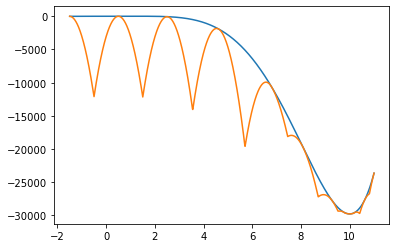

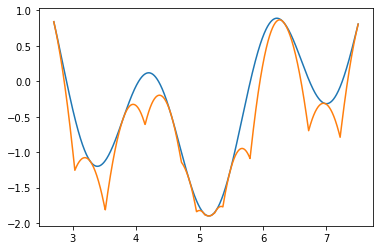

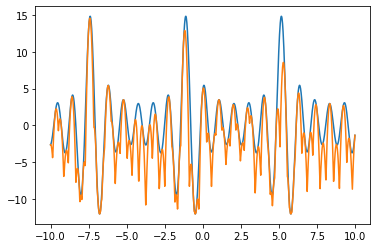

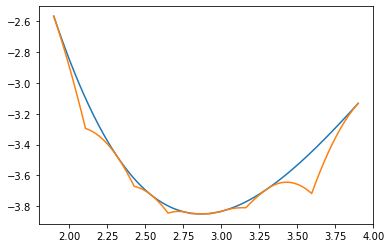

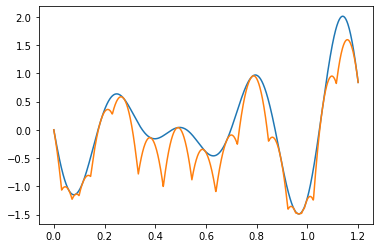

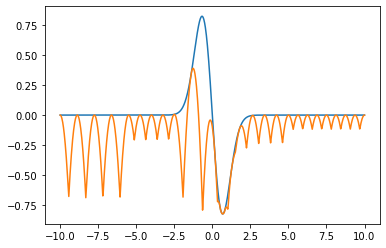

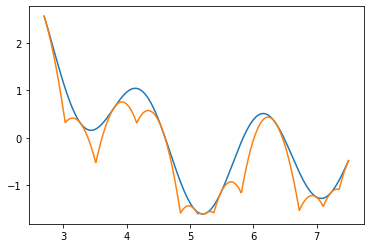

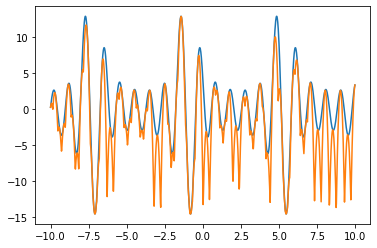

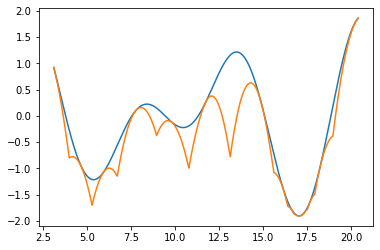

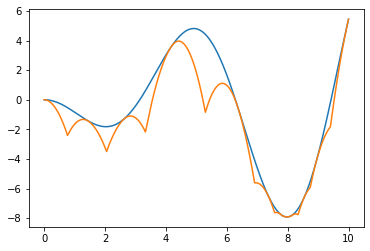

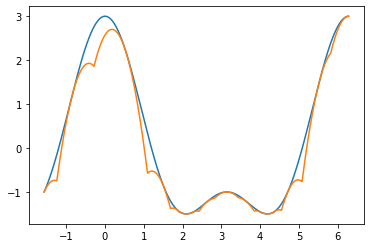

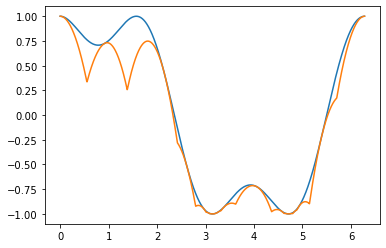

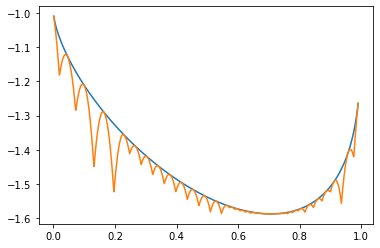

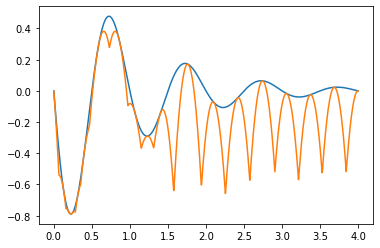

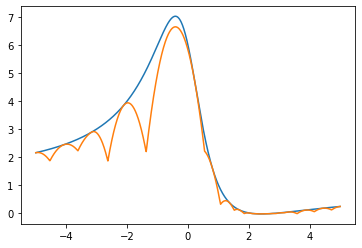

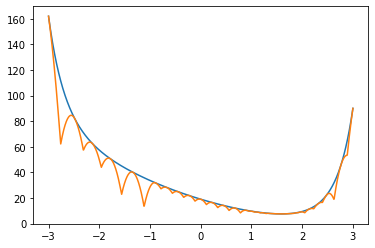

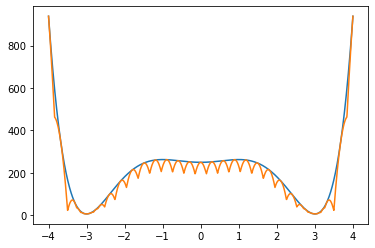

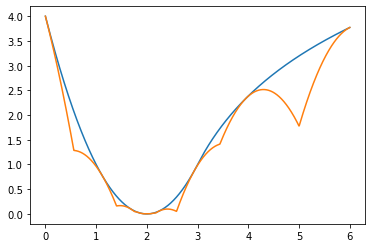

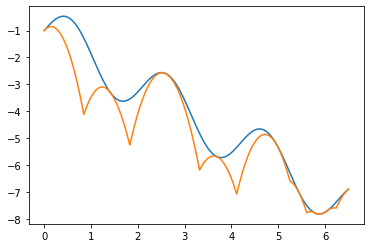

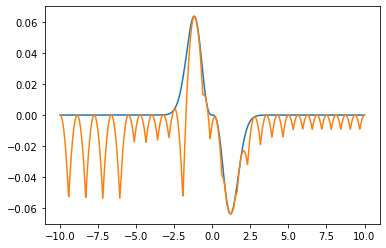

In [22]:
 for index in range(20):
    plt.plot(xarrays[index], yarrays[index])
    plt.plot(xarrays[index], ogarrays[index])
    plt.show()